In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "blastchar/telco-customer-churn",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-3690047211.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'telco-customer-churn' dataset.
First 5 records:    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic            

In [4]:
import pandas as pd
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
!pip install xgboost shap imbalanced-learn --quiet


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import shap

sns.set_style("whitegrid")


In [7]:
df.drop("customerID", axis=1, inplace=True)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


/tmp/ipython-input-2762580214.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


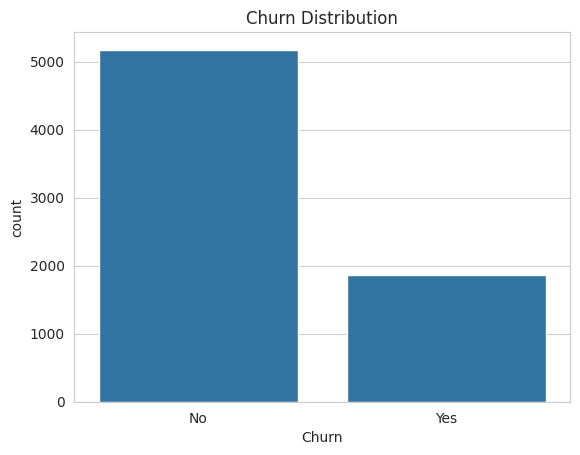

In [8]:
plt.figure()
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()


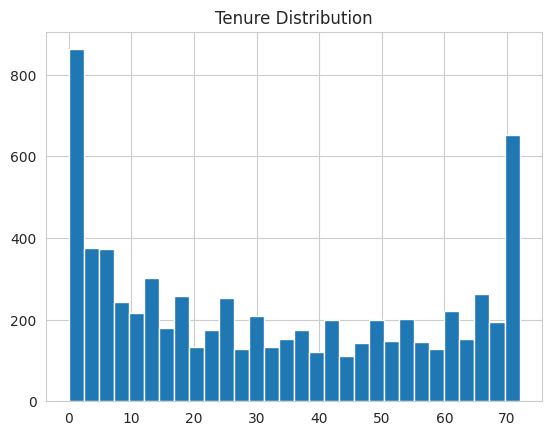

In [9]:
plt.figure()
plt.hist(df["tenure"], bins=30)
plt.title("Tenure Distribution")
plt.show()


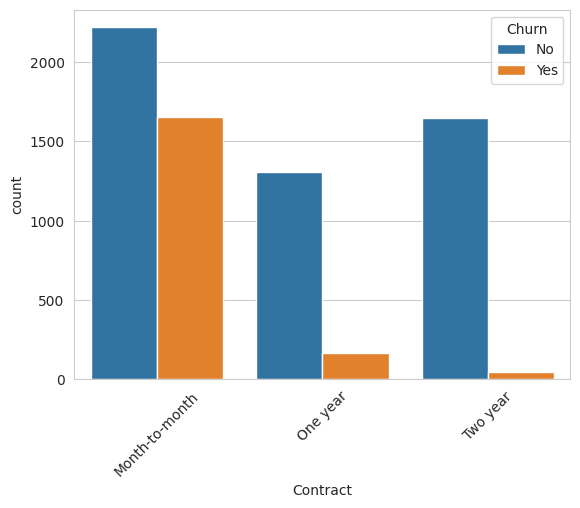

In [10]:
plt.figure()
sns.countplot(x="Contract", hue="Churn", data=df)
plt.xticks(rotation=45)
plt.show()


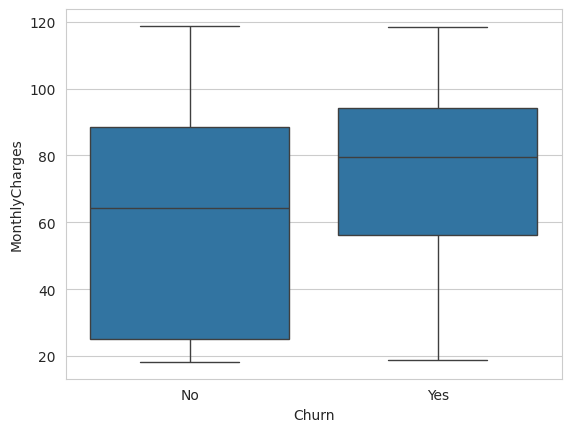

In [11]:
plt.figure()
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.show()


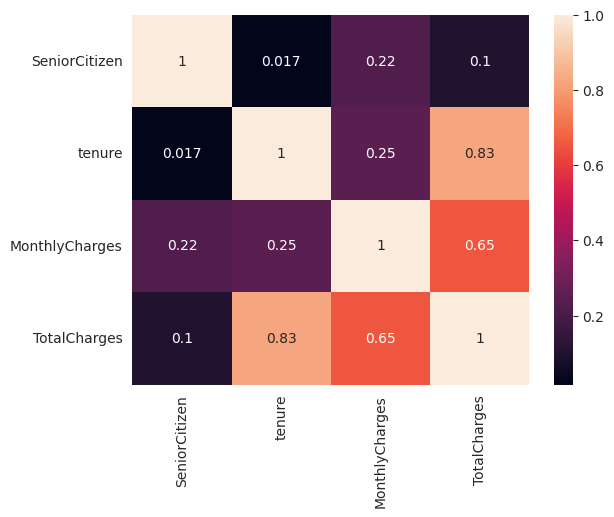

In [12]:
numeric_df = df.select_dtypes(include=["int64","float64"])
plt.figure()
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()


In [13]:
le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col])


In [14]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [16]:
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)


In [17]:
lr = LogisticRegression()
lr.fit(X_train_sm, y_train_sm)

y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))


Logistic Regression
Accuracy: 0.7650816181689141
Precision: 0.5387453874538746
Recall: 0.7828418230563002
F1 Score: 0.6382513661202186


In [22]:
predict_proba = lr.predict_proba(X_test_scaled)
print(predict_proba)

[[0.1152184  0.8847816 ]
 [0.93713449 0.06286551]
 [0.99832808 0.00167192]
 ...
 [0.96617453 0.03382547]
 [0.99064586 0.00935414]
 [0.36687822 0.63312178]]


In [23]:
import numpy as np

new_customer = np.array([[
    0,  # gender
    0,  # SeniorCitizen
    0,  # Partner
    0,  # Dependents
    5,  # tenure
    1,  # PhoneService
    0,  # MultipleLines
    1,  # InternetService
    0,  # OnlineSecurity
    0,  # OnlineBackup
    0,  # DeviceProtection
    0,  # TechSupport
    1,  # StreamingTV
    1,  # StreamingMovies
    2,  # Contract
    1,  # PaperlessBilling
    1,  # PaymentMethod
    85.5,  # MonthlyCharges
    400    # TotalCharges
]])


In [24]:
new_scaled = scaler.transform(new_customer)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [25]:
prediction = lr.predict(new_scaled)
probability = lr.predict_proba(new_scaled)[:,1]

print("Churn Prediction:", "Yes" if prediction[0] == 1 else "No")
print("Churn Probability:", probability[0])


Churn Prediction: Yes
Churn Probability: 0.5998509368774184
